In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from ncmcm.bundlenet.bundlenet import BunDLeNet, train_model
from ncmcm.bundlenet.utils import prep_data, timeseries_train_test_split
from ncmcm.visualisers.latent_space import LatentSpaceVisualiser
from ray import tune, train
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.bayesopt import BayesOptSearch

In [2]:
algorithm = 'BunDLeNet_HPO'
rat_name = 'gatsby' # ['achilles', 'gatsby','cicero', 'buddy']
data = np.load(f'../../data/raw/rat_hippocampus/{rat_name}.npz')
x, b = data['x'], data['b']
x = x - np.min(x)

In [3]:
def train_bundlenet(config):    
    # Extract hyperparameters from the config dictionary
    learning_rate = config["learning_rate"]
    latent_dim = int(config["latent_dim"])
    n_epochs = int(config["n_epochs"])
    win = int(config["win"])
    
    x_, b_ = prep_data(x, b, win=win)

    x_train, x_test, b_train_1, b_test_1 = timeseries_train_test_split(x_, b_)

    model = BunDLeNet(latent_dim=latent_dim, num_behaviour=b_train_1.shape[1])

    train_history, test_history = train_model(
        x_train,
        b_train_1,
        model,
        b_type='continuous',
        gamma=0.9,
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        initialisation= (5, 10),
        validation_data=(x_test, b_test_1),
        report_ray_tune=False,
    )

In [5]:
max_epochs = 100
search_space = {
    "win": tune.loguniform(1, 50),
    "learning_rate": tune.loguniform(1e-5, 1e-1),
    "latent_dim": tune.uniform(1,4),
    "n_epochs": tune.uniform(5, max_epochs)
}
scheduler = ASHAScheduler(
    time_attr="epoch",
    metric="val_loss",
    mode="min", 
    max_t=max_epochs, 
    grace_period=5, 
    reduction_factor=2
)
search_algo = BayesOptSearch(metric="val_loss", mode="min")

tuner = tune.Tuner(
    tune.with_parameters(train_bundlenet),
    tune_config=tune.TuneConfig(
        search_alg=search_algo,
        num_samples=100,
        scheduler=scheduler,
        max_concurrent_trials=6
    ),
    param_space=search_space,
)
results = tuner.fit()

2024-09-30 17:22:49,104	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'latent_dim': 2.835560015082157, 'learning_rate': 0.013959250783934358, 'n_epochs': 32.75374729563572, 'win': 18.951733624310137}.
2024-09-30 17:22:49,751	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'latent_dim': 2.835560015082157, 'learning_rate': 0.013959250783934358, 'n_epochs': 32.75374729563572, 'win': 18.951733624310137}.
2024-09-30 17:22:50,366	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'latent_dim': 2.835560015082157, 'learning_rate': 0.013959250783934358, 'n_epochs': 32.75374729563572, 'win': 18.951733624310137}.
2024-09-30 17:22:50,976	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'latent_dim': 2.835560015082157, 'learning_rate': 0.013959250783934358, 'n_epochs': 32.75374729563572, 'win': 18.951733624310137}.
2024-09-30 17:25:30,955	INFO tune.py:1042 -- Total run time: 3171.83 seconds (3171.74 seconds for the tuning loop).


In [6]:
best_result = results.get_best_result(metric='val_loss', mode='min')
print("Minimum validation loss:", best_result.metrics['val_loss'])
print("Best hyperparameters found were: ", best_result.config)


Minimum validation loss: 0.010163084305822849
Best hyperparameters found were:  {'win': 18.951730321390894, 'learning_rate': 0.013957991126597664, 'latent_dim': 2.8355586841671383, 'n_epochs': 32.75374161084572}


In [10]:
learning_rate = best_result.config["learning_rate"]
latent_dim = int(best_result.config["latent_dim"])
n_epochs = int(best_result.config["n_epochs"])
win = int(best_result.config["win"])

In [29]:

latent_dim = 3
learning_rate = 0.010503 
n_epochs = 22
win = 33
"""
"""

'\n'

In [30]:
x_, b_ = prep_data(x, b, win=win)
x_train, x_test, b_train_1, b_test_1 = timeseries_train_test_split(x_, b_)
model = BunDLeNet(latent_dim=latent_dim, num_behaviour=b_.shape[1])
train_history, test_history = train_model(
    x_train,
    b_train_1,
    model,
    b_type='continuous',
    gamma=0.9,
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    initialisation=(5,10),
    validation_data=(x_test, b_test_1),
)
print(f'val loss: {test_history[-1,-1]}')

Loss [Markov, Behaviour, Total]: [0.0051 0.0102 0.0153]: 100%|█| 10/10 [00:06<0


model: 0 val loss: 0.008973847478628158


Loss [Markov, Behaviour, Total]: [0.0038 0.0141 0.0179]: 100%|█| 10/10 [00:06<0


model: 1 val loss: 0.013641599118709564


Loss [Markov, Behaviour, Total]: [0.0049 0.0107 0.0156]: 100%|█| 10/10 [00:08<0


model: 2 val loss: 0.009834667537361383


Loss [Markov, Behaviour, Total]: [0.0049 0.0114 0.0163]: 100%|█| 10/10 [00:06<0


model: 3 val loss: 0.01094601457938552


Loss [Markov, Behaviour, Total]: [0.004  0.0149 0.0189]: 100%|█| 10/10 [00:07<0


model: 4 val loss: 0.017492256693076344


Loss [Markov, Behaviour, Total]: [0.0048 0.0075 0.0123]: 100%|█| 22/22 [00:16<0

val loss: 0.00789451302960515


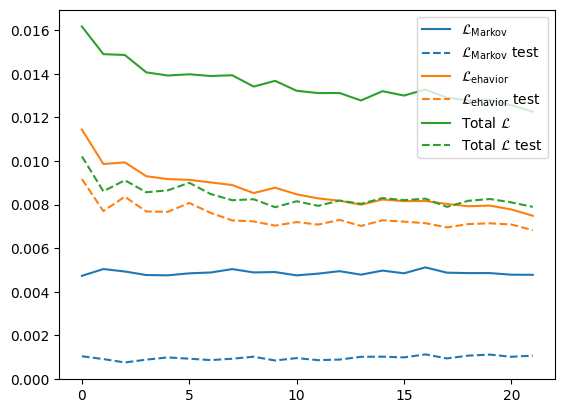

In [31]:
plt.figure()
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, label in enumerate([
    r"$\mathcal{L}_{\mathrm{Markov}}$",
    r"$\mathcal{L}_{\mathrm{ehavior}}$",
    r"Total $\mathcal{L}$"
]):
    plt.plot(train_history[:, i], label=label, c=colors[i])
    plt.plot(test_history[:, i], label=label + ' test', c=colors[i], linestyle='--')
plt.legend()

In [35]:
# Projecting into latent space
y0_tr = model.tau(x_train[:, 0]).numpy()
y1_tr = model.tau(x_train[:, 1]).numpy()

y0_tst = model.tau(x_test[:, 0]).numpy()
y1_tst = model.tau(x_test[:, 1]).numpy()

y0_ = model.tau(x_[:, 0]).numpy()
y1_ = model.tau(x_[:, 1]).numpy()

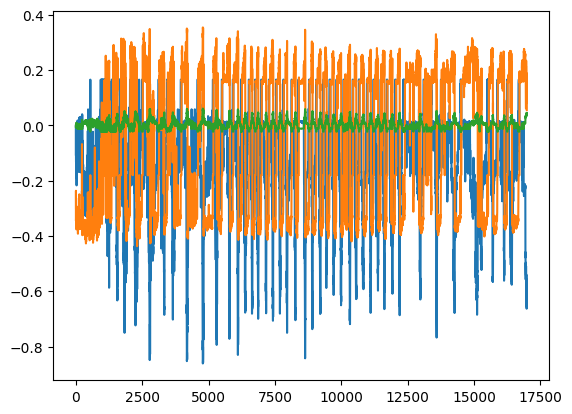

In [36]:
%matplotlib inline
plt.figure()
plt.plot(y0_)

In [37]:
"""
y0_tr = np.c_[y0_tr, np.zeros_like(y0_tr[:,0])]
y1_tr = np.c_[y1_tr, np.zeros_like(y1_tr[:,0])]
y0_tst = np.c_[y0_tst, np.zeros_like(y0_tst[:,0])]
y1_tst = np.c_[y1_tst, np.zeros_like(y1_tst[:,0])]
"""
y0_tr

array([[-1.0533488e-01, -3.4133089e-01,  1.8918887e-04],
       [-3.0424505e-02, -3.3828622e-01, -6.4723492e-03],
       [ 7.7039003e-06, -2.3634422e-01, -8.0514736e-03],
       ...,
       [-6.3359463e-01,  6.6023767e-02,  4.3193720e-02],
       [-6.5116554e-01,  1.2918243e-01,  4.4282153e-02],
       [-5.5912447e-01,  5.5316493e-02,  3.6895484e-02]], dtype=float32)

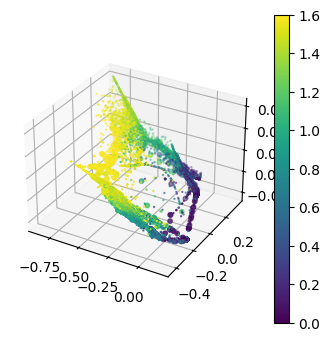

In [38]:
%matplotlib inline
# Continuous variable plotting
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')
# ax.axis('off')
tr_pts = ax.scatter(y0_tr[:, 0], y0_tr[:, 1], y0_tr[:, 2], c=b_train_1[:, 0], s=0.5)
tst_pts = ax.scatter(y0_tst[:, 0], y0_tst[:, 1], y0_tst[:, 2], c=b_test_1[:, 0], s=10)
plt.colorbar(tr_pts)
plt.show()

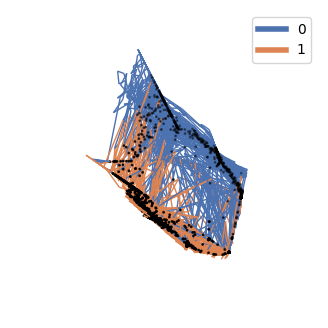

In [39]:
# Discrete variable plotting
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')

vis = LatentSpaceVisualiser(
    y=y0_tr,
    b=b_train_1[:, 1].astype(int),
    b_names=['0', '1']
)
fig, ax = vis._plot_ps(fig, ax, arrow_length_ratio=0.0001)

vis = LatentSpaceVisualiser(
    y=y0_tst,
    b=b_test_1[:, 1].astype(int),
    b_names=['0', '1'],
    show_points=True
)
fig, ax = vis._plot_ps(fig, ax, arrow_length_ratio=0.1)

plt.show()

In [40]:
save_data=True
if save_data:
    # Save the weights
    model.save_weights(f'../../data/generated/BunDLeNet_model_rat_{rat_name}')
    print(f'../../data/generated/saved_Y/y0_tr__{algorithm}_rat_{rat_name}')
    np.savetxt(f'../../data/generated/saved_Y/y0_tr__{algorithm}_rat_{rat_name}', y0_tr)
    np.savetxt(f'../../data/generated/saved_Y/y1_tr__{algorithm}_rat_{rat_name}', y1_tr)
    np.savetxt(f'../../data/generated/saved_Y/y0_tst__{algorithm}_rat_{rat_name}', y0_tst)
    np.savetxt(f'../../data/generated/saved_Y/y1_tst__{algorithm}_rat_{rat_name}', y1_tst)
    np.savetxt(f'../../data/generated/saved_Y/b_train_1__{algorithm}_rat_{rat_name}', b_train_1)
    np.savetxt(f'../../data/generated/saved_Y/b_test_1__{algorithm}_rat_{rat_name}', b_test_1)


../../data/generated/saved_Y/y0_tr__BunDLeNet_HPO_rat_gatsby
